In [32]:
# import moduel은 그냥 복붙한거라서 어떤게 맞을지 잘 모릅니다

import numpy as np
import pandas as pd
from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from xgboost import plot_importance
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tnrange, tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import catboost
from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [33]:
def fill_na_mode(data):   
    # fill with mode. (최빈값 fillna)
    fill_null_list = list(data.columns)
    for col in fill_null_list:
        data[col].fillna(data[col].mode()[0],inplace=True)

    return data

def country_imputation(data):
    
    data.loc[(data.country == 'IMN'), 'country'] = 'GBR'
    data.loc[(data.country == 'REU'), 'country'] = 'MDG'
    data.loc[(data.country == 'ZWE'), 'country'] = 'ZAF'
    data.loc[(data.country == 'SWZ'), 'country'] = 'ZAF'
    data.loc[(data.country == 'LKA'), 'country'] = 'ZAF'
    data.loc[(data.country == 'SLE'), 'country'] = 'ZAF'
    data.loc[(data.country == 'BFA'), 'country'] = 'ZAF'
    data.loc[(data.country == 'TZA'), 'country'] = 'ZAF'
    data.loc[(data.country == 'BOL'), 'country'] = 'ZAF'
    data.loc[(data.country == 'PSE'), 'country'] = 'ZAF'
    data.loc[(data.country == 'MDA'), 'country'] = 'UKR'
    data.loc[(data.country == 'CYM'), 'country'] = 'JAM'
    data.loc[(data.country == 'NIC'), 'country'] = 'JAM'
    data.loc[(data.country == 'MCO'), 'country'] = 'USA'
    data.loc[(data.country == 'MNE'), 'country'] = 'COL'
    data.loc[(data.country == 'GRD'), 'country'] = 'VEN'
    data.loc[(data.country == 'LCA'), 'country'] = 'VEN'
    data.loc[(data.country == 'VUT'), 'country'] = 'AUS'
    data.loc[(data.country == 'BLZ'), 'country'] = 'BRA'
    data.loc[(data.country == 'ATG'), 'country'] = 'PRI'
    data.loc[(data.country == 'JEY'), 'country'] = 'FRA'
    data.loc[(data.country == 'HTI'), 'country'] = 'DOM'
    data.loc[(data.country == 'FSM'), 'country'] = 'NAM'
    data.loc[(data.country == 'SSD'), 'country'] = 'ARM'
    return data
    

# VCL 모두 삭제
def drop_vcl(df):
    
    col_list = [f'VCL{i}' for i in range(1, 17)] 
    
    for col in col_list:
        df.drop(col, axis=1, inplace=True)
    
    return df

# Q 답변 변환
def q_data(data):
    
    Q_list = [f'Q{i}' for i in range(1, 27)]
    reverse_list = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17']
    
    for rev in reverse_list: 
        data[rev] = 6 - data[rev]
        
    data['Mach_score'] = data[Q_list].mean(axis = 1)
    
    return data

# TIPI feature  engineering 
def tipi_engineering(data):
    
    data['Conscientiousness'] = (data['TIPI3']+(6-data['TIPI8']))/2
    data['Agreeableness'] = (data['TIPI7']+(6-data['TIPI2']))/2
    data['Neuroticism'] = (data['TIPI9']+(6-data['TIPI4']))/2
    data['openness'] = (data['TIPI5']+(6-data['TIPI10']))/2
    data['extraversion'] = (data['TIPI1']+(6-data['TIPI6']))/2
    
    for x in [2, 4, 6, 8, 10]:
        data[f'TIPI{x}'] = 6 - data[f'TIPI{x}']
    
    return data

# correlation이 낮은 introelapse 제거 
def drop_introelapse(data):
    
    data.drop('introelapse', axis=1, inplace=True)
    
    return data

# one-hot encoding 적용 
def onehot_encoding(data):
    
    onehot_list = ['education','urban', 'gender', 'engnat', 'hand', 'religion', 'orientation','voted', 'married', 'ASD', 'country']

    for col in onehot_list:
        data = pd.get_dummies(data = data, columns = [col], prefix = col)

    return data

# ageband로 묶어서 age 계산
def ageband(data):
    data['ageBand'] = -1
    data.loc[(data['age'] > 12) & (data['age'] <= 20.0), 'ageBand'] = 1
    data.loc[(data['age'] > 20.0) & (data['age'] <= 26.0), 'ageBand'] = 2
    data.loc[(data['age'] > 26.0) & (data['age'] < 130), 'ageBand'] = 3
    data.drop('age',axis=1,inplace=True)
    return data

def outlier_func(data):
    
    for i in ['testelapse','surveyelapse']:
        data.loc[data[i]>6000,i] = 6000

    #familysize
    data.loc[data['familysize']>10,'familysize'] = 10
  
    return data
'''
def country_func(data):
    
    temp = data['country'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    country_list = list(temp[temp['counts']>10]['unique_values'].unique())
    data.loc[~data['country'].isin(country_list),'country'] = 'others'
    data = pd.get_dummies(data = data, columns = ['country'], prefix = 'country')
    return data
'''

"\ndef country_func(data):\n    \n    temp = data['country'].value_counts().rename_axis('unique_values').reset_index(name='counts')\n    country_list = list(temp[temp['counts']>10]['unique_values'].unique())\n    data.loc[~data['country'].isin(country_list),'country'] = 'others'\n    data = pd.get_dummies(data = data, columns = ['country'], prefix = 'country')\n    return data\n"

In [34]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.min_rows', 30)

def processing_data(data):
    data = country_imputation(data)
    data = outlier_func(data)
    data = drop_introelapse(data)
    data = drop_vcl(data)
    data = fill_na_mode(data)
    data = onehot_encoding(data)
    data = q_data(data)
    data = tipi_engineering(data)
    data = ageband(data)
    # data = country_func(data) # 여기서 문제 발생. 
    
    return data

In [35]:
train_df = pd.read_csv('./competition_data/train.csv', index_col=0)
test_df = pd.read_csv('./competition_data/test.csv', index_col=0)
sample_submission = pd.read_csv('./competition_data/sample_submission.csv')

train_df = processing_data(train_df)
test_df = processing_data(test_df)

train_X = train_df.drop('nerdiness', axis = 1)
train_Y = train_df['nerdiness']

In [36]:
train_df.shape, test_df.shape, train_X.shape, train_Y.shape

((15000, 222), (35452, 221), (15000, 221), (15000,))

In [45]:
params = {
    'max_depth': 10, 
    'learning_rate': 0.00976136092905561, 
    'n_estimators': 9400, 
    'colsample_bytree': 0.8543754171382677, 
    'colsample_bylevel': 0.9629904399168124, 
    'colsample_bynode': 0.8248938119302215, 
    'reg_lambda': 0.19485954543028522, 
    'reg_alpha': 0.06999603044690161, 
    'subsample': 0.75, 
    'min_child_weight': 2, 
    'gamma': 0.11753760508543808
    }
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(train_X, train_Y)

y_pred = xgb_model.predict(test_df)
sample_submission['nerdiness'] = y_pred

In [48]:
sample_submission.to_csv('sample_submission.csv', index=False)

## different perspective

In [37]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=123 )

In [38]:
# get_clf_eval()
# 저번에 작성한 것에 ROC AUC를 추가함
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))
    
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

# precision_recall_curve_plot()
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

In [40]:
dtrain, dtest = xgb.DMatrix(X_train, y_train), xgb.DMatrix(X_test, y_test)

In [41]:
params = {
    'max_depth': 10, 
    'learning_rate': 0.00976136092905561, 
    'n_estimators': 9400, 
    'colsample_bytree': 0.8543754171382677, 
    'colsample_bylevel': 0.9629904399168124, 
    'colsample_bynode': 0.8248938119302215, 
    'reg_lambda': 0.19485954543028522, 
    'reg_alpha': 0.06999603044690161, 
    'subsample': 0.75, 
    'min_child_weight': 2, 
    'gamma': 0.11753760508543808
    }
num_rounds = 10000

In [42]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params, dtrain, num_rounds, early_stopping_rounds=100, evals=wlist)

[23:43:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.49775	eval-rmse:0.49869
[1]	train-rmse:0.49556	eval-rmse:0.49727
[2]	train-rmse:0.49331	eval-rmse:0.49592
[3]	train-rmse:0.49114	eval-rmse:0.49456
[4]	train-rmse:0.48903	eval-rmse:0.49332
[5]	train-rmse:0.48681	eval-rmse:0.49205
[6]	train-rmse:0.48470	eval-rmse:0.49084
[7]	train-rmse:0.48256	eval-rmse:0.48960
[8]	train-rmse:0.48056	eval-rmse:0.48841
[9]	train-rmse:0.47846	eval-rmse:0.48726
[10]	train-rmse:0.47638	eval-rmse:0.48610
[11]	train-rmse:0.47439	eval-rmse:0.48489
[12]	train-rmse:0.47229	eval-rmse:0.48370
[13]	train-rm

In [43]:
pred_probs = xgb_model.predict(dtest)
preds = [1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[ 972  373]
 [ 272 1383]]
정확도: 0.7850, 정밀도: 0.7876, 재현율: 0.8356, F1: 0.8109, AUC:0.7792


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

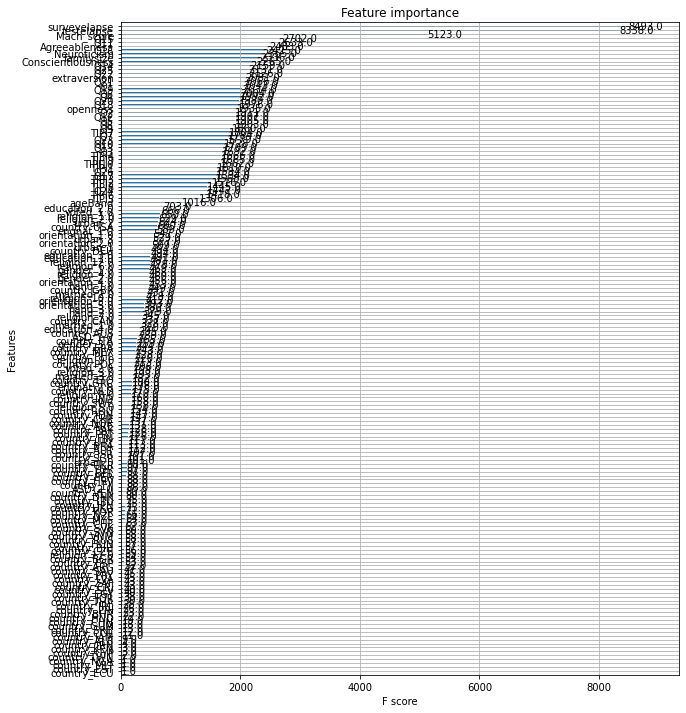

In [44]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)